In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import multiprocessing
import gc

data_cfg = {
    'Input_param_names': ['ambient',
                          'coolant',
                          'u_d',
                          'u_q',
                          'motor_speed',
                          #'torque',
                          'i_d',
                          'i_q'
                           ],
    'Target_param_names': ['pm',
                           'stator_yoke',
                           'stator_tooth',
                           'stator_winding'
                          ],
    # for ewm and statistical moments
    'drop': None,  #[p for p in range(40, 400)],  #['46', '47'],
    'downsample_rate': 1,
    'rolling_lookback': [840, 6360, 3360, 1320],
    'valset': [81],
    'testset': [65, 72],
    'loss': 'mse',
    # profile ids to drop (don't need to actually exist)

    # paths
    'file_path': "measures.csv",
    'db_path': 'results.db',
    'model_dump_path': 'output/',
    'save_predictions': True,
    'random_seed': 2019,
    'downsample_val_test': True,
    'db_target_scheme': ['pm', 'stator_yoke', 'stator_tooth', 'stator_winding'],
}

# Load dataset
path = 'measures.csv'
conversion_table = {col: np.float32 for col in data_cfg['Input_param_names'] + data_cfg['Target_param_names']}
conversion_table.update({'profile_id': np.uint8})
dataset = pd.read_csv(path, dtype=conversion_table)

# Drop specified profiles if any
if data_cfg['drop'] is not None:
    drop_p_l = [int(p) for p in data_cfg['drop']]
    dataset.drop(index=dataset[dataset['profile_id'].isin(drop_p_l)].index, inplace=True)

# Select relevant columns
x_cols = data_cfg['Input_param_names']
y_cols = data_cfg['Target_param_names']
dataset = dataset.loc[:, x_cols + y_cols + ['profile_id']]

# Create time column
# dataset['time'] = dataset.groupby('profile_id').cumcount() * 0.5

# Create extra features
def calculate_i_s(row):
    return np.sqrt(row['i_d']**2 + row['i_q']**2)

def calculate_u_s(row):
    return np.sqrt(row['u_d']**2 + row['u_q']**2)

def calculate_P_el(row):
    return row['i_s'] * row['u_s']

if set(['i_d', 'i_q', 'u_d', 'u_q']).issubset(set(dataset.columns.tolist())):
    dataset['i_s'] = dataset.apply(calculate_i_s, axis=1)
    dataset['u_s'] = dataset.apply(calculate_u_s, axis=1)
    dataset['P_el'] = dataset.apply(calculate_P_el, axis=1)

# Function to create lag features
def create_lag_features(args):
    df, lookback = args
    dfs = []
    for lback in range(lookback, lookback + 1, lookback):
        lag_feats = [
            df.shift(lback).astype(np.float32).fillna(df.iloc[0, :]).add_suffix(f'_lag_{lback}'),
            df.diff(periods=lback).astype(np.float32).fillna(df.iloc[0, :]).add_suffix(f'_lag_{lback}_diff')
        ]
        lag_feats += [
            abs(lag_feats[1]).astype(np.float32).add_suffix('_abs'),
            pd.DataFrame(df.values + lag_feats[0].values, columns=df.columns).add_suffix(f'_sum')
        ]
        dfs.append(pd.concat(lag_feats, axis=1))
    return pd.concat(dfs, axis=1)

# Function to create rolling features
def create_rolling_features(args):
    df, lookback = args
    dummy = np.zeros((lookback, len(df.columns)))
    dummy = pd.DataFrame(dummy, columns=df.columns)
    df = pd.concat([dummy, df], axis=0, ignore_index=True)
    ew_mean = pd.concat([df.ewm(span=lb).mean().astype(np.float32).rename(columns=lambda c: c + '_ew_rolling_mean_' + str(lb)) for lb in [lookback]], axis=1)
    ew_std = pd.concat([df.ewm(span=lb).std().astype(np.float32).rename(columns=lambda c: c + '_ew_rolling_std_' + str(lb)) for lb in [lookback]], axis=1)
    return pd.concat([ew_mean, ew_std], axis=1).iloc[lookback + 1:, :].reset_index(drop=True)

# Apply feature creation in parallel
profiles_df = [dataset.loc[dataset['profile_id'] == int(p), :].reset_index(drop=True) for p in dataset['profile_id'].unique().tolist()]
with multiprocessing.Pool(2) as pool:
    lag_feats = pool.map(create_lag_features, [(df, data_cfg['downsample_rate']) for df in profiles_df])
    rolling_feats = pool.map(create_rolling_features, [(df, data_cfg['rolling_lookback'][0]) for df in profiles_df])

# Merge features together
merged_profiles_df = [pd.concat([df] + [lag_feats[i], rolling_feats[i]], axis=1) for i, df in enumerate(profiles_df)]
dataset = pd.concat(merged_profiles_df, axis=0, ignore_index=True)

# Standardize the data
scaler = StandardScaler()
float_cols = x_cols + y_cols
dataset[float_cols] = scaler.fit_transform(dataset[float_cols].astype(float))

# Clean up
gc.collect()

# Save or return the processed dataset
dataset.to_csv('processed_dataset_base.csv', index=False)

2025-03-15 11:58:12.450301: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742020092.497818    5880 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742020092.510924    5880 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742020092.612871    5880 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742020092.612904    5880 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742020092.612906    5880 computation_placer.cc:177] computation placer alr

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 7)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 128, 64)   │        960 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 64)   │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 64)   │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 128, 64)   │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 128, 64)   │        512 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 64)   │          0 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 64)   │          0 │ conv1d_2[0][0],   │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 128, 64)   │      8,256 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128, 64)   │          0 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ dropout_2[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 4)         │        260 │ global_max_pooli… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,012 (74.27 KB)

 Trainable params: 18,628 (72.77 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 58.9326 - rmse: 3.2254 - val_loss: 21.0469 - val_rmse: 1.2576
Epoch 2/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 36.4009 - rmse: 1.5627 - val_loss: 16.4673 - val_rmse: 0.9586
Epoch 3/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 28.4187 - rmse: 1.1519 - val_loss: 13.2242 - val_rmse: 0.7931
Epoch 4/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 23.7557 - rmse: 1.0224 - val_loss: 11.1697 - val_rmse: 0.7440
Epoch 5/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 20.5548 - rmse: 0.9659 - val_loss: 9.6793 - val_rmse: 0.7198
Epoch 6/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 17.8680 - rmse: 0.9572 - val_loss: 8.5053 - val_rmse: 0.7183
Epoch 7/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 15.7319 - rmse: 0.9503 - val_loss: 7.5500 - val_rmse: 0.7139
Epoch 8/50
253/253 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 13.8460 - rmse: 0.9485 - val_loss: 6.7139 - val_rmse: 0.6939
Epoch 9/50
253/253 ━

Test Loss: 0.9897, Test RMSE: 0.6288


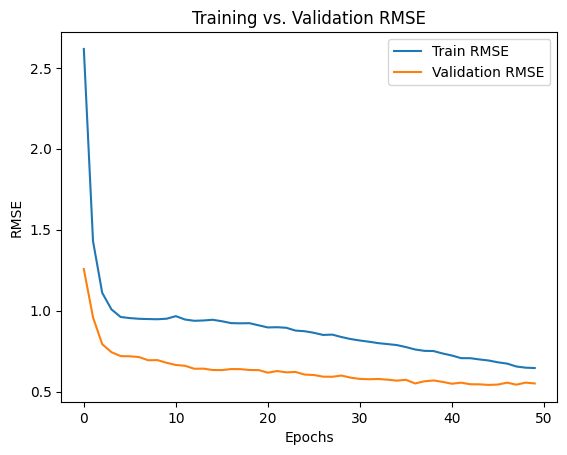

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers, models, optimizers, regularizers
from keras.callbacks import EarlyStopping
from keras.losses import MeanSquaredError

# Custom RMSE metric
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

# Load dataset
dataset = pd.read_csv('processed_dataset_base.csv')

# Define validation and test profile IDs
valset = [78, 79, 81]
testset = [27, 29, 30, 31, 65, 72, 4,  5,  6]

# Split dataset
train_profiles = dataset[~dataset['profile_id'].isin(valset + testset)]
val_profiles = dataset[dataset['profile_id'].isin(valset)]
test_profiles = dataset[dataset['profile_id'].isin(testset)]

# Feature and target columns
x_cols = ['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
y_cols = ['pm', 'stator_yoke', 'stator_tooth', 'stator_winding']

X_train, y_train = train_profiles[x_cols].values, train_profiles[y_cols].values
X_val, y_val = val_profiles[x_cols].values, val_profiles[y_cols].values
X_test, y_test = test_profiles[x_cols].values, test_profiles[y_cols].values

# Lookback window
# lookback = 10  
lookback = 128

# Reshape function for CNN
def reshape_data(X, y, lookback):
    num_samples = (X.shape[0] // lookback) * lookback
    X, y = X[:num_samples], y[:num_samples]
    X = X.reshape((num_samples // lookback, lookback, X.shape[1]))  # (batch, time_steps, features)
    y = y[lookback - 1::lookback]  
    return X, y

X_train, y_train = reshape_data(X_train, y_train, lookback)
X_val, y_val = reshape_data(X_val, y_val, lookback)
X_test, y_test = reshape_data(X_test, y_test, lookback)

# CNN Model
def build_cnn_model(x_shape, arch='plain', n_layers=3, n_units=64, activation='relu', 
                    kernel_size=3, dilation_start_rate=1, regularization_rate=1e-4, 
                    dropout_rate=0.3, optimizer='adam', lr_rate=5e-5, loss='mse', n_outputs=4):
    assert arch in ['plain', 'res'], "Specified architecture not recognized!"

    opts_map = {
        'adam': optimizers.Adam, 'nadam': optimizers.Nadam, 
        'adamax': optimizers.Adamax, 'sgd': optimizers.SGD, 
        'rmsprop': optimizers.RMSprop
    }

    # Model Configuration
    cnn_cfg = {
        'x_shape': x_shape, 'arch': arch, 'n_filters': int(n_units), 
        'kernel_size': int(kernel_size), 'dilation_start_rate': int(dilation_start_rate), 
        'n_layers': int(n_layers), 'activation': activation, 'dropout_rate': dropout_rate, 
        'reg_rate': regularization_rate, 'batchnorm': activation != 'selu', 
        'n_outputs': n_outputs
    }

    model = cnn_network(**cnn_cfg)

    opt = opts_map[optimizer](learning_rate=lr_rate)
    model.compile(optimizer=opt, loss=loss, metrics=[rmse])
    model.summary()
    return model

# CNN Network with Residual Option
def cnn_network(x_shape, arch, n_filters, kernel_size, dilation_start_rate,
                n_layers, activation, dropout_rate=0.5, reg_rate=1e-6,
                batchnorm=True, n_outputs=4):
    
    regs = {
        'kernel_regularizer': regularizers.l2(reg_rate),
        'bias_regularizer': regularizers.l2(reg_rate),
        'activity_regularizer': regularizers.l2(reg_rate)
    }

    def add_common_layers(z):
        if batchnorm:
            z = layers.BatchNormalization()(z)
        z = layers.Activation(activation)(z)
        z = layers.Dropout(dropout_rate)(z)  
        return z

    x = layers.Input(shape=x_shape)
    y = x  

    for i in range(n_layers):
        dilation_rate = dilation_start_rate * (2 ** i)

        if i % 2 == 0 and arch == 'res':
            shortcut = y  

        y = layers.Conv1D(n_filters, kernel_size, padding='causal', 
                          dilation_rate=dilation_rate, activation=None, **regs)(y)
        y = add_common_layers(y)

        if i % 2 == 1 and arch == 'res':
            shortcut = layers.Conv1D(n_filters, kernel_size=1, padding='causal', 
                                     activation=None, **regs)(shortcut)
            y = layers.add([shortcut, y])

    y = layers.GlobalMaxPooling1D()(y)
    y = layers.Dense(n_outputs)(y)  

    model = models.Model(inputs=x, outputs=y)
    return model

# Build CNN Model
cnn_model = build_cnn_model(x_shape=(lookback, len(x_cols)), arch='res', 
                            n_layers=3, n_units=64, activation='relu', 
                            kernel_size=2, dilation_start_rate=1, 
                            regularization_rate=1e-4, dropout_rate=0.3, 
                            optimizer='adam', lr_rate=5e-5, loss='mse', 
                            n_outputs=len(y_cols))

early_stopping = EarlyStopping(monitor='val_rmse', patience=10, restore_best_weights=True, mode='min')

# Train the model
history = cnn_model.fit(X_train, y_train, epochs=50, batch_size=32, 
                        validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluate model
test_loss, test_rmse = cnn_model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test RMSE: {test_rmse:.4f}')

# Save model
cnn_model.save('cnn_time_series_model.h5')
import json

# Save the history dictionary to a JSON file
with open("training_history_cnn_time_series_model.json", "w") as f:
    json.dump(history.history, f)

# Plot RMSE over epochs
plt.plot(history.history['rmse'], label='Train RMSE')
plt.plot(history.history['val_rmse'], label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.title('Training vs. Validation RMSE')
plt.show()


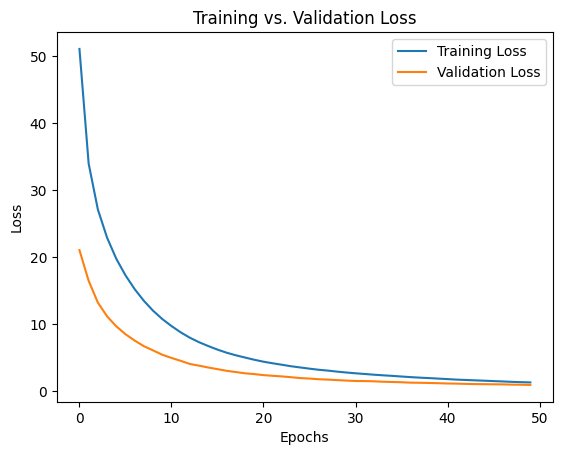

In [2]:
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.show()


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


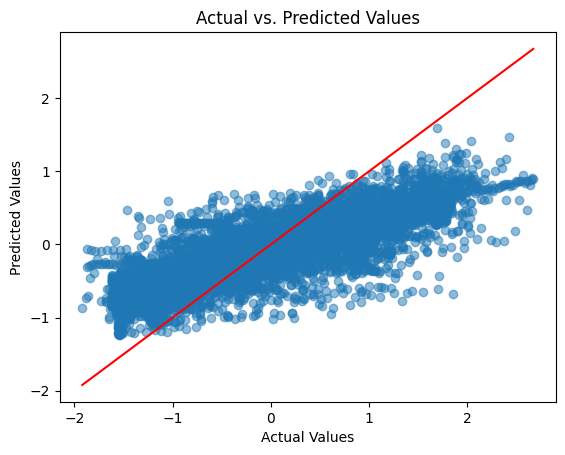

In [3]:
import numpy as np
import matplotlib.pyplot as plt

y_pred = cnn_model.predict(X_test)

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Use np.min() and np.max() to handle arrays correctly
min_val = np.min(y_test)
max_val = np.max(y_test)
plt.plot([min_val, max_val], [min_val, max_val], color='red')  # 45-degree line

plt.show()


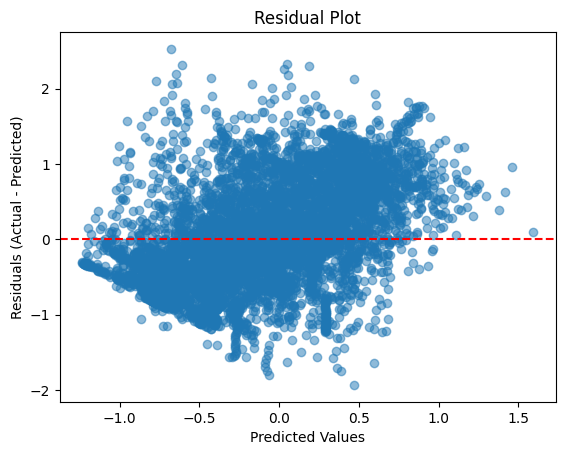

In [4]:
residuals = y_test - y_pred

plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.show()


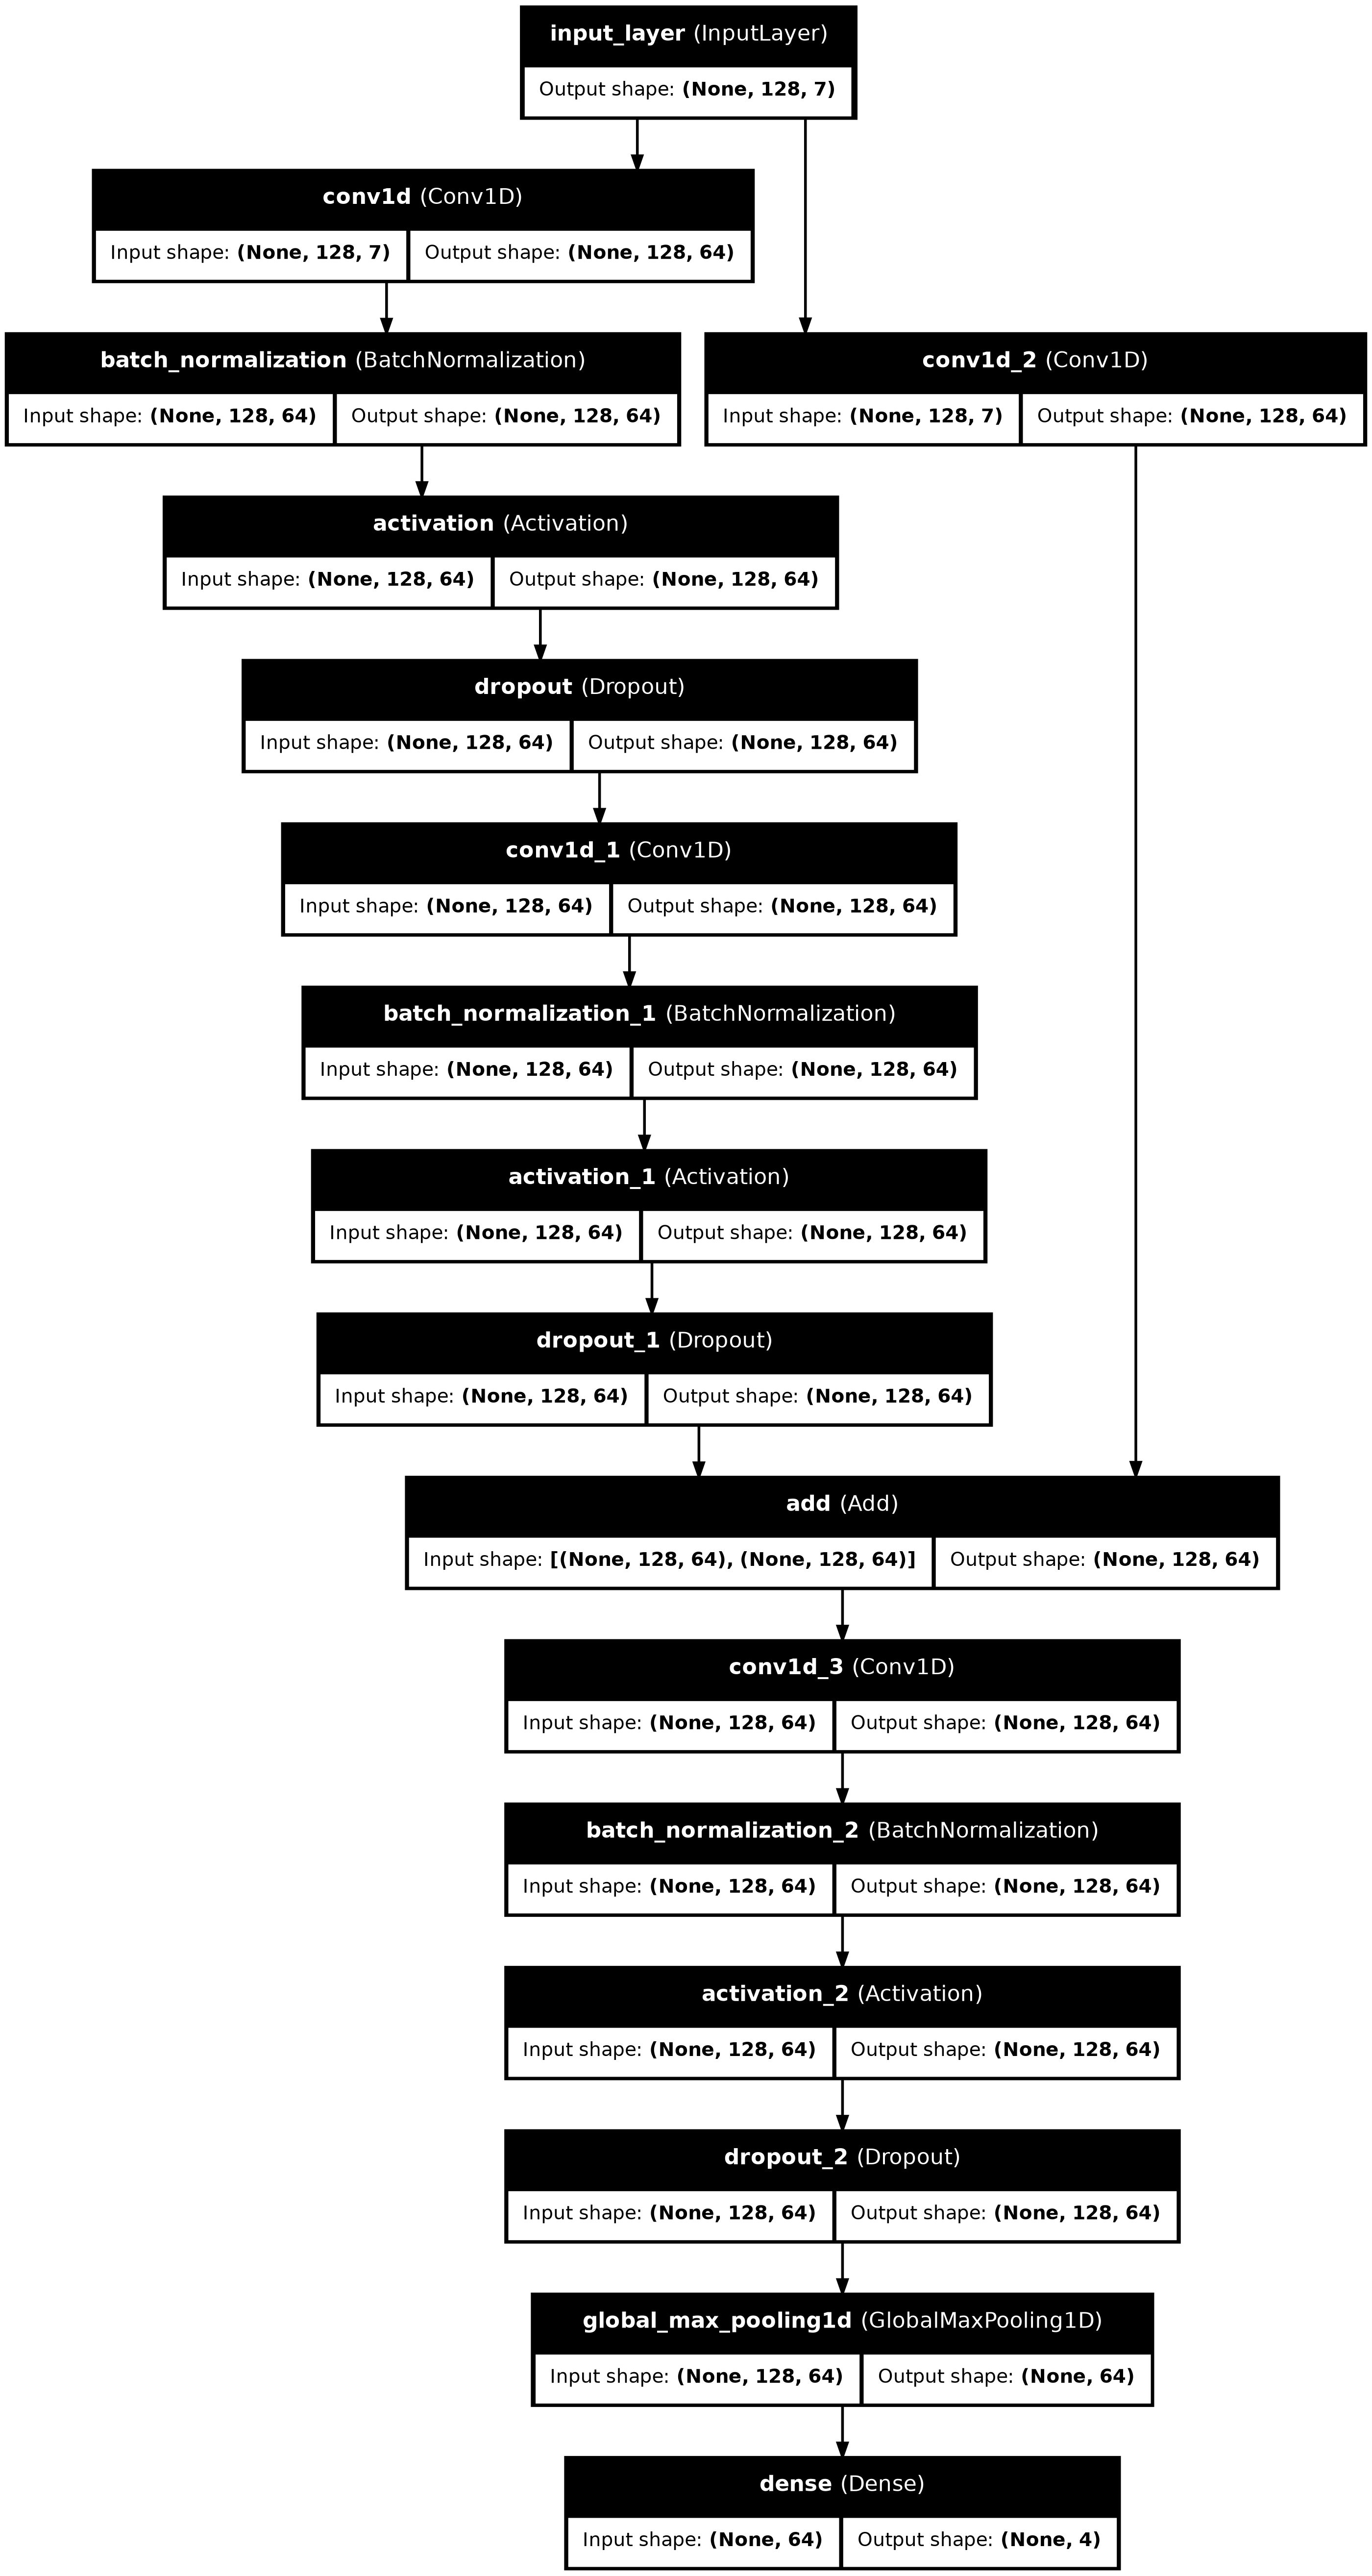

In [6]:
from tensorflow.keras.utils import plot_model

plot_model(cnn_model, show_shapes=True, show_layer_names=True, to_file='cnn_model.png')


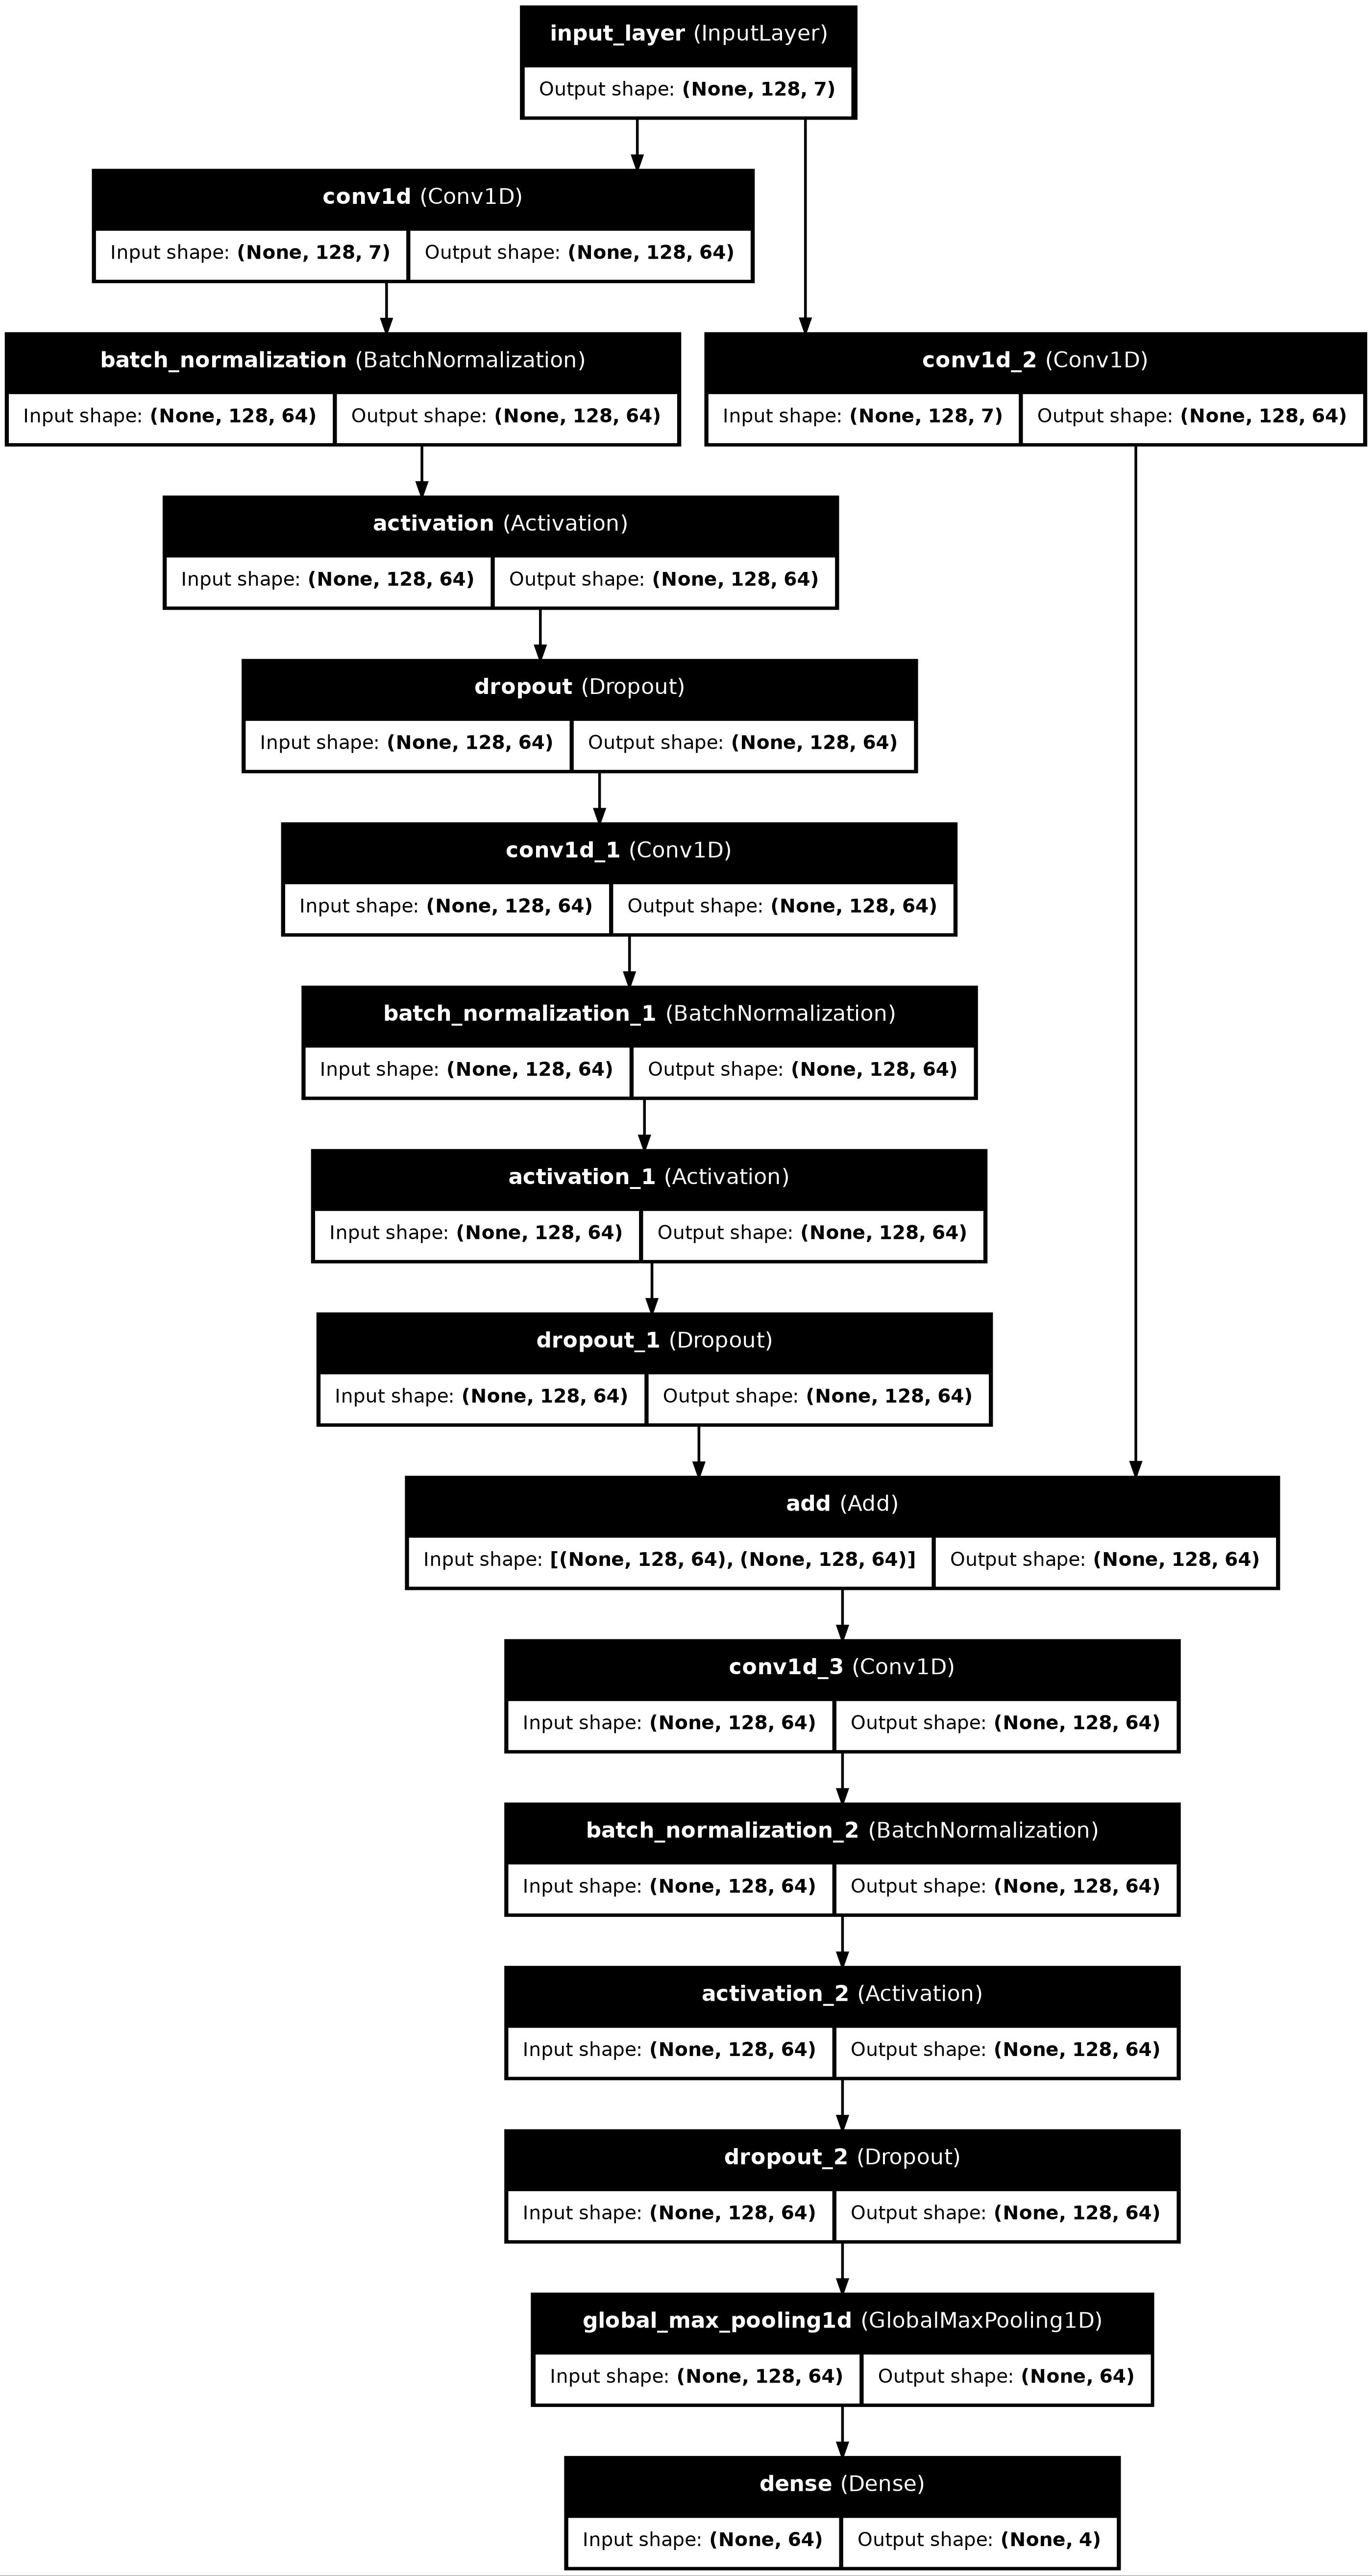

In [7]:
from keras.models import load_model
import tensorflow as tf

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

model = load_model('cnn_time_series_model.h5', custom_objects={'rmse': rmse, 'mse': tf.keras.losses.MeanSquaredError()})


import io
from IPython.display import Image
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_structure.jpg')
